### Import các thư viện

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
import matplotlib.pyplot as plt
import get_data_regulary as gdr
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import joblib



In [42]:
matches_df = pd.read_csv("data_to_4-11-2024.csv")
# Từ điển chuẩn hóa tên đội
team_corrections = {
          'Manchester United': ['Man United', 'Manchester United'],
          'Manchester City': ['Man City', 'Manchester City'],
          'Newcastle United': ['Newcastle', 'Newcastle United'],
          'Wolverhampton Wanderers': ['Wolverhampton', 'Wolverhampton Wanderers'],
          'Brighton': ['Brighton', 'Brighton Hove'],
          'Sheffield United': ['Sheffield United', 'Sheffield Utd'],
          'Nottingham Forest': ['Nottingham', 'Nottingham Forest'],
          'Leicester': ['Leicester', 'Leicester City']
          }

# Hàm chuẩn hóa tên đội bóng
def normalize_team_name(team_name):
     for standard_name, variations in team_corrections.items():
          if team_name in variations:
               return standard_name
     return team_name
     
matches_df['Đội Chủ Nhà'] = matches_df['Đội Chủ Nhà'].apply(normalize_team_name)
matches_df['Đội Khách'] = matches_df['Đội Khách'].apply(normalize_team_name)



### Huấn luyện mô hình


In [43]:

# Đặc trưng
matches_df['Phong Độ Gần Đây Đội Nhà'] = matches_df.groupby('Đội Chủ Nhà')['Kết quả'].transform(lambda x: x.rolling(3, min_periods=1).mean())
matches_df['Phong Độ Gần Đây Đội Khách'] = matches_df.groupby('Đội Khách')['Kết quả'].transform(lambda x: x.rolling(3, min_periods=1).mean())

so_tran_thang_doi_nha = matches_df[matches_df['Kết quả'] == 0].groupby('Đội Chủ Nhà').size()
tong_so_tran_doi_nha = matches_df.groupby('Đội Chủ Nhà').size()
ti_le_thang_doi_nha = (so_tran_thang_doi_nha / tong_so_tran_doi_nha).fillna(0)
matches_df['Tỉ Lệ Thắng Đội Nhà'] = matches_df['Đội Chủ Nhà'].map(ti_le_thang_doi_nha)

so_tran_thang_doi_khach = matches_df[matches_df['Kết quả'] == 1].groupby('Đội Khách').size()  
tong_so_tran_doi_khach = matches_df.groupby('Đội Khách').size()  
ti_le_thang_doi_khach = (so_tran_thang_doi_khach / tong_so_tran_doi_khach).fillna(0)
matches_df['Tỉ Lệ Thắng Đội Khách'] = matches_df['Đội Khách'].map(ti_le_thang_doi_khach)

so_tran_hoa_doi_nha = matches_df[matches_df['Kết quả'] == 2].groupby('Đội Chủ Nhà').size()  # Số trận hòa của đội chủ nhà
ti_le_hoa_doi_nha = (so_tran_hoa_doi_nha / tong_so_tran_doi_nha).fillna(0)
matches_df['Tỉ Lệ Hòa Đội Nhà'] = matches_df['Đội Chủ Nhà'].map(ti_le_hoa_doi_nha)

so_tran_hoa_doi_khach = matches_df[matches_df['Kết quả'] == 2].groupby('Đội Khách').size()  # Số trận hòa của đội khách
ti_le_hoa_doi_khach = (so_tran_hoa_doi_khach / tong_so_tran_doi_khach).fillna(0)
matches_df['Tỉ Lệ Hòa Đội Khách'] = matches_df['Đội Khách'].map(ti_le_hoa_doi_khach)

matches_df['Số Bàn Trung Bình Đội Nhà'] = matches_df.groupby('Đội Chủ Nhà')['Bàn Thắng Đội Nhà'].transform('mean')

matches_df['Số Bàn Trung Bình Đội Khách'] = matches_df.groupby('Đội Khách')['Bàn Thắng Đội Khách'].transform('mean')

matches_df['Hiệu Số Bàn Thắng Đội Nhà'] = matches_df.groupby('Đội Chủ Nhà')['Bàn Thắng Đội Nhà'].transform('mean') - matches_df.groupby('Đội Chủ Nhà')['Bàn Thắng Đội Khách'].transform('mean')

matches_df['Hiệu Số Bàn Thắng Đội Khách'] = matches_df.groupby('Đội Khách')['Bàn Thắng Đội Khách'].transform('mean') - matches_df.groupby('Đội Khách')['Bàn Thắng Đội Nhà'].transform('mean')

     # Thêm các đặc trưng thống kê và đối đầu
matches_df['Sạch Lưới Đội Nhà'] = matches_df.groupby('Đội Chủ Nhà')['Bàn Thắng Đội Khách'].transform(lambda x: (x == 0).sum())

matches_df['Sạch Lưới Đội Khách'] = matches_df.groupby('Đội Khách')['Bàn Thắng Đội Nhà'].transform(lambda x: (x == 0).sum())

matches_df['Thành Tích Đối Đầu Đội Nhà'] = matches_df.groupby(['Đội Chủ Nhà', 'Đội Khách'])['Kết quả'].transform(lambda x: (x == 0).sum())

matches_df['Thành Tích Đối Đầu Đội Khách'] = matches_df.groupby(['Đội Khách', 'Đội Chủ Nhà'])['Kết quả'].transform(lambda x: (x == 1).sum())

     # Tạo các đặc trưng mới từ sự chênh lệch bàn thắng, chuỗi thắng/thua gần đây
matches_df['Chênh Lệch Bàn Thắng Nhà-Khách'] = matches_df['Hiệu Số Bàn Thắng Đội Nhà'] - matches_df['Hiệu Số Bàn Thắng Đội Khách']

matches_df['Chênh Lệch Phong Độ Gần Đây'] = matches_df['Phong Độ Gần Đây Đội Nhà'] - matches_df['Phong Độ Gần Đây Đội Khách']

matches_df['Chuỗi Thắng Đội Nhà'] = matches_df.groupby('Đội Chủ Nhà')['Kết quả'].transform(lambda x: x.eq(0).rolling(5, min_periods=1).sum())

matches_df['Chuỗi Thắng Đội Khách'] = matches_df.groupby('Đội Khách')['Kết quả'].transform(lambda x: x.eq(1).rolling(5, min_periods=1).sum())


In [44]:
print(matches_df['Kết quả'].value_counts())

Kết quả
0    1654
1    1166
2     852
Name: count, dtype: int64


In [45]:
# Chuẩn bị dữ liệu
le = LabelEncoder()
matches_df['Đội Chủ Nhà'] = le.fit_transform(matches_df['Đội Chủ Nhà'])
matches_df['Đội Khách'] = le.transform(matches_df['Đội Khách'])

X = matches_df[['Đội Chủ Nhà', 'Đội Khách', 'Phong Độ Gần Đây Đội Nhà', 'Phong Độ Gần Đây Đội Khách', 
                'Tỉ Lệ Thắng Đội Nhà', 'Tỉ Lệ Thắng Đội Khách', 'Tỉ Lệ Hòa Đội Nhà', 'Tỉ Lệ Hòa Đội Khách', 
                'Số Bàn Trung Bình Đội Nhà', 'Số Bàn Trung Bình Đội Khách', 'Hiệu Số Bàn Thắng Đội Nhà', 
                'Hiệu Số Bàn Thắng Đội Khách', 'Sạch Lưới Đội Nhà', 'Sạch Lưới Đội Khách', 
                'Thành Tích Đối Đầu Đội Nhà', 'Thành Tích Đối Đầu Đội Khách', 'Chênh Lệch Bàn Thắng Nhà-Khách', 
                'Chênh Lệch Phong Độ Gần Đây', 'Chuỗi Thắng Đội Nhà', 'Chuỗi Thắng Đội Khách']]

# Nhân trọng số cho Tỉ Lệ Thắng để tăng cường ảnh hưởng
X.loc[:, 'Tỉ Lệ Thắng Đội Nhà'] *= 10
X.loc[:, 'Tỉ Lệ Thắng Đội Khách'] *= 10

y = matches_df['Kết quả']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng SMOTE để cân bằng lớp
smote = SMOTE(sampling_strategy={0: int(len(y) * 0.5), 
                                1: int(len(y) * 0.5), 
                                2: int(len(y) * 0.3)}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


# Mô hình RandomForest với trọng số lớp
rf_model = RandomForestClassifier(random_state=42, class_weight={0: 2, 1: 1.5, 2: 1}, 
                                  bootstrap=False, max_depth=15, min_samples_leaf=2, 
                                  min_samples_split=2, n_estimators=500)

# Mô hình XGBoost
xgb_model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', 
                          random_state=42)

# Sử dụng Stacking để kết hợp mô hình RandomForest và XGBoost
estimators = [('rf', rf_model), ('xgb', xgb_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Huấn luyện mô hình
stacking_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = stacking_model.predict(X_test)

# Đánh giá kết quả
print("Accuracy on test set:", np.round(accuracy_score(y_test, y_pred), 2))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy on test set: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84       357
           1       0.85      0.86      0.85       388
           2       0.80      0.79      0.80       210

    accuracy                           0.84       955
   macro avg       0.83      0.83      0.83       955
weighted avg       0.84      0.84      0.84       955



In [46]:
print("Độ chính xác của mô hình trên tập Test:", np.round(accuracy_score(y_test, y_pred), 2))

Độ chính xác của mô hình trên tập Test: 0.84


In [47]:
from sklearn.metrics import roc_auc_score

# Tính AUC-ROC cho các lớp đa nhãn
auc_score = roc_auc_score(y_test, stacking_model.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC (đa nhãn):", auc_score)


AUC-ROC (đa nhãn): 0.9482333590858171


### Phân tích kết quả dự đoán bằng Ma Trận Nhầm Lẫn (confusion matrix)

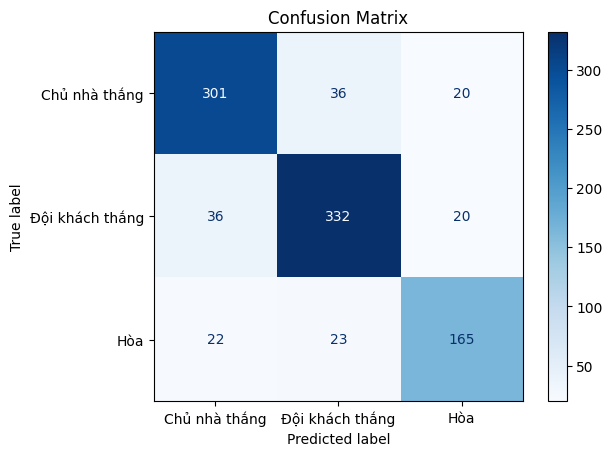

In [48]:
# Hiển thị confusion matrix để phân tích chi tiết kết quả dự đoán
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Chủ nhà thắng', 'Đội khách thắng', 'Hòa'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Đánh giá mô hình bằng Cross-validation

In [49]:
# Cross-validation giúp đánh giá độ chính xác trên nhiều phần khác nhau của dữ liệu
cv_scores_stacking_model = cross_val_score(stacking_model, X_scaled, y, cv=5)

print("Đánh giá trung bình của mô hình trên 5 phần khác nhau của dữ liệu :",
       np.mean(cv_scores_stacking_model))

Đánh giá trung bình của mô hình trên 5 phần khác nhau của dữ liệu : 0.7992919238540103
